In [1]:
### import library
import glob
import imageio

import os
import time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from IPython.display import clear_output

from tensorflow_examples.models.pix2pix import pix2pix
from IPython import display

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE


/opt/conda/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.10.0-dev20220423). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:

### fix config
# Define the standard image size.
orig_img_size = (512, 512)
# Size of the random crops to be used during training.
input_img_size = (1, 512, 512, 3)

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

### parameters
buffer_size = 256
batch_size = 1 
EPOCHS = 2000
directory = 'hockney/'
version = 'v8/'
weight_name = '1000_epochs'
version_dir = './weight_files/' + directory + version

per_save = 50


### load dataset
# original_picture
ds_ori = tf.keras.utils.image_dataset_from_directory('../images/real_hockney', batch_size=batch_size, image_size = orig_img_size, shuffle=False)

# pixel_art
ds_tar = tf.keras.utils.image_dataset_from_directory('../images/hockney', batch_size=batch_size, image_size = orig_img_size, shuffle=False)

# custom_testset
ds_cus = tf.keras.utils.image_dataset_from_directory('../images/custom_hockney', batch_size=batch_size, image_size = orig_img_size, shuffle=False)


### preprocessing
# normalize_image
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

### train dataset preprocessing
def preprocess_train_image(img, label):
    # # to grayscale
    # img = tf.image.rgb_to_grayscale(img, name=None)
    # # to rgb
    # img = tf.image.grayscale_to_rgb(img)
    # # Random flip
    # img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


### test dataset preprocessing
def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
#     img = tf.image.resize(img, [input_img_size[1], input_img_size[2]])

    img = normalize_img(img)
    return img


### preprocessing
ds_ori_t = ds_ori.map(preprocess_train_image, num_parallel_calls=autotune).cache()

ds_tar_t = ds_tar.map(preprocess_train_image, num_parallel_calls=autotune).cache()

ds_cus_t = ds_cus.map(preprocess_train_image, num_parallel_calls=autotune).cache()



Found 64 files belonging to 1 classes.
Found 63 files belonging to 1 classes.
Found 7 files belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


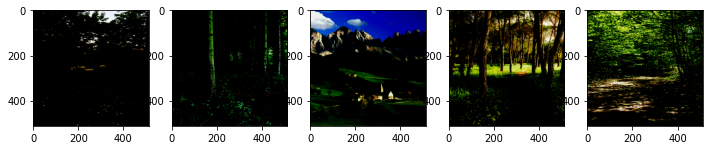

In [3]:
plt.figure(figsize=(12, 12))
for idx, img in enumerate(ds_ori_t):
    plt.subplot(2, 5, idx+1)
    plt.imshow(img[0])
    
    if idx == 4:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


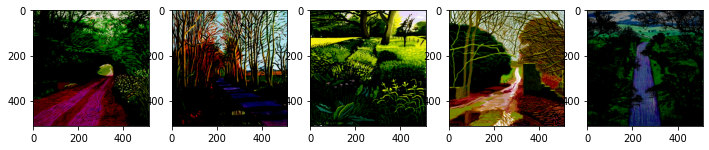

In [4]:
plt.figure(figsize=(12, 12))
for idx, img in enumerate(ds_tar_t):
    plt.subplot(2, 5, idx+1)
    plt.imshow(img[0])
    
    if idx == 4:
        break

In [5]:
# generator and discriminator
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)



generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



In [6]:
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

In [7]:
def generate_images(model, test_input, dir_, idx, epochs):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        
        plt.axis('off')
        
    prediction = keras.preprocessing.image.array_to_img(prediction[0])
    prediction = prediction.resize((600,600))
    
    directory = f"./saved_images/{dir_}/"
    
    exist_dir = os.path.exists(directory)
    
    if not exist_dir:
        os.makedirs(directory)
    
    file_path = directory + f"epochs_{str(epochs).zfill(2)}_{idx}.png".format(i=i)
    prediction.save(file_path)

    plt.show()

In [21]:
def save_ori_image(dataset_, dir_):
    for idx, img in enumerate(ds_cus_t.take(len(dataset_))):
        ori_ = keras.preprocessing.image.array_to_img(img[0])
        ori_ = ori_.resize((600,600))
        
        directory = f"./saved_images/{dir_}/"
        
        filename_ = directory + f"epochs_00_{idx}.png"
        
        ori_.save(filename_)

In [22]:
# checkpoint_dir = './weight_files/hockney/v4'

In [23]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)

In [24]:
# latest

In [25]:
# ckpt.restore(latest)
# ckpt.restore('./weight_files/hockney/v5/1000_epochs-21')

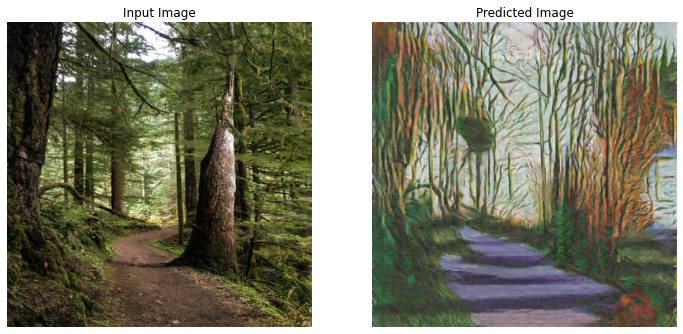

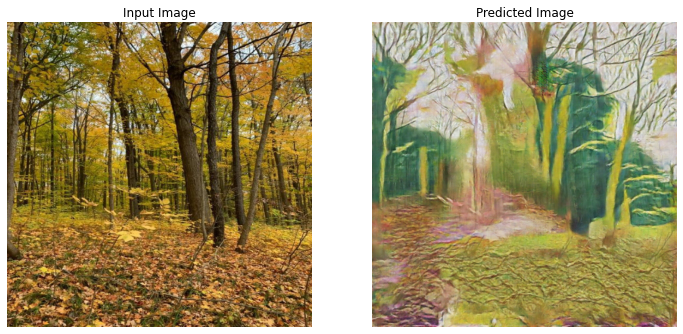

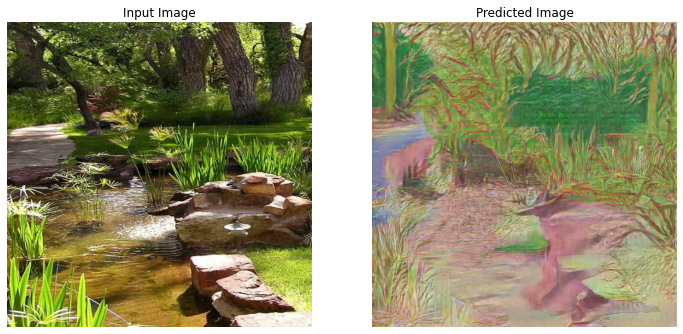

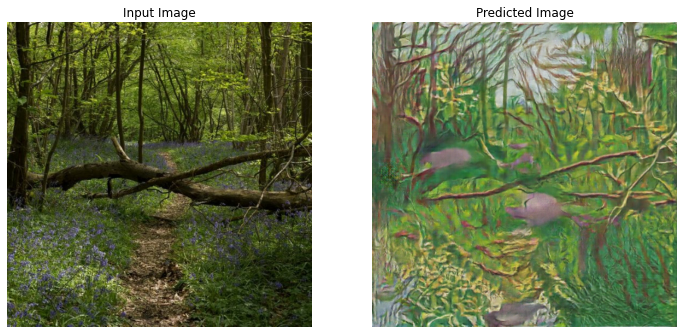

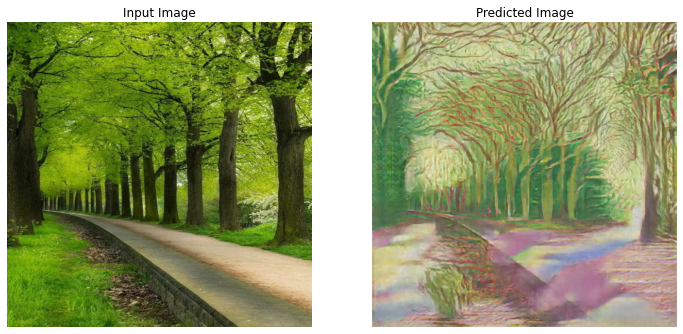

In [55]:
# ckpt.restore(latest)
dir_ = 'cus_'
epochs_ = 20
ckpt.restore(f'./weight_files/hockney/v7/1000_epochs-{epochs_}')

for idx, img in enumerate(ds_cus_t.take(63)):
    generate_images(ckpt.generator_g, img, dir_, idx, epochs_)

In [28]:
dir_ = 'cus_'

## save original image
save_ori_image(ds_cus_t, dir_)    

## save all epochs image
for i in range(1, 21):
    # ckpt.restore(latest)
    epochs_ = i
    ckpt.restore(f'./weight_files/hockney/v7/1000_epochs-{epochs_}')

    for idx, img in enumerate(ds_cus_t.take(7)):
        generate_images(ckpt.generator_g, img, dir_, idx, epochs_)

In [70]:
def save_gif(idx, dir_, filename_, duration_, du_first, du_final):
    with imageio.get_writer(filename_, mode='I', duration=duration_) as writer:
        filenames = glob.glob(f'./saved_images/{dir_}/epochs_*_{idx}.png')
        filenames = sorted(filenames)
        last = -1
        
        for _ in range(du_first):
            image = imageio.imread(filenames[0])
            writer.append_data(image)
        
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        ## final picture add more
        for _ in range(du_final):
            image = imageio.imread(filename)
            writer.append_data(image)

    import IPython
    if IPython.version_info > (6,2,0,''):
        display.Image(filename=filename_)
 


In [72]:
dir_ = 'cus_'

for idx in range(7):
    
    anim_file = f'cycle_gan_{idx}.gif'

    save_gif(idx, dir_, anim_file, 0.11, 7, 15)

In [ ]:
# idx = 6
# dir_ = 'cus_'

# anim_file = f'cycle_gan_{idx}.gif'

# with imageio.get_writer(anim_file, mode='I', duration=0.2) as writer:
#     filenames = glob.glob(f'./saved_images/{dir_}/epochs_*_{idx}.png')
#     filenames = sorted(filenames)
#     last = -1
#     for i,filename in enumerate(filenames):
#         frame = 2*(i**0.5)
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
#         image = imageio.imread(filename)
#         writer.append_data(image)
#     ## final picture add more
#     for _ in range(15):
#         image = imageio.imread(filename)
#         writer.append_data(image)

# import IPython
# if IPython.version_info > (6,2,0,''):
#     display.Image(filename=anim_file)